# EDA (Exploratory Data Analysis)
* Dataset from the [CanYouReadIt?](https://canyoureadit.com) project
* The survey was conducted starting from **4/20/2021.** This is an ongoing survey, but the current data has been exported from the online database at **4/20/2022.**

In [1]:
##### Project Constants #######################################
from constants import (SAVEPATH, EXPORTDIR, T, ENDTIME)
##### Common Libraries for EDA ################################
import os
os.environ['NUMEXPR_MAX_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '8'
import numpy as np
from platform import python_version
import jupyterlab
import pandas as pd
import random
import numexpr as ne
print(f"{T.b}Packages{T.E}")
print(f"Python: {python_version()}")
print(f"JupterLab: {jupyterlab.__version__}")
print(f"Pandas: {pd.__version__}")
##### MatPlotLib #############################################
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime as dt
import matplotlib.font_manager
FONT_SIZE = 24
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['grid.color'] = '#333333'
plt.rcParams['grid.linestyle'] = 'dotted'
plt.rcParams['grid.linewidth'] = 1
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
%config InlineBackend.figure_format ='retina'
# %matplotlib widget

Packages
Python: 3.9.12
JupterLab: 3.3.2
Pandas: 1.4.1


In [2]:
df = pd.read_csv(SAVEPATH,
                 index_col=0,
                 sep=',',
                 parse_dates = ["create_dt"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56275 entries, 0 to 16989
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   image_id       56275 non-null  int64         
 1   create_dt      56275 non-null  datetime64[ns]
 2   session_id     56275 non-null  int64         
 3   mobile_user    56275 non-null  bool          
 4   mobile_image   56275 non-null  bool          
 5   response_yes   56275 non-null  bool          
 6   response_no    56275 non-null  bool          
 7   response_skip  56275 non-null  bool          
dtypes: bool(5), datetime64[ns](1), int64(2)
memory usage: 2.0 MB


# Images viewed

In [4]:
print(f"{len(df)} images viewed in {len(df['session_id'].unique())} unique sessions.")

56275 images viewed in 51159 unique sessions.


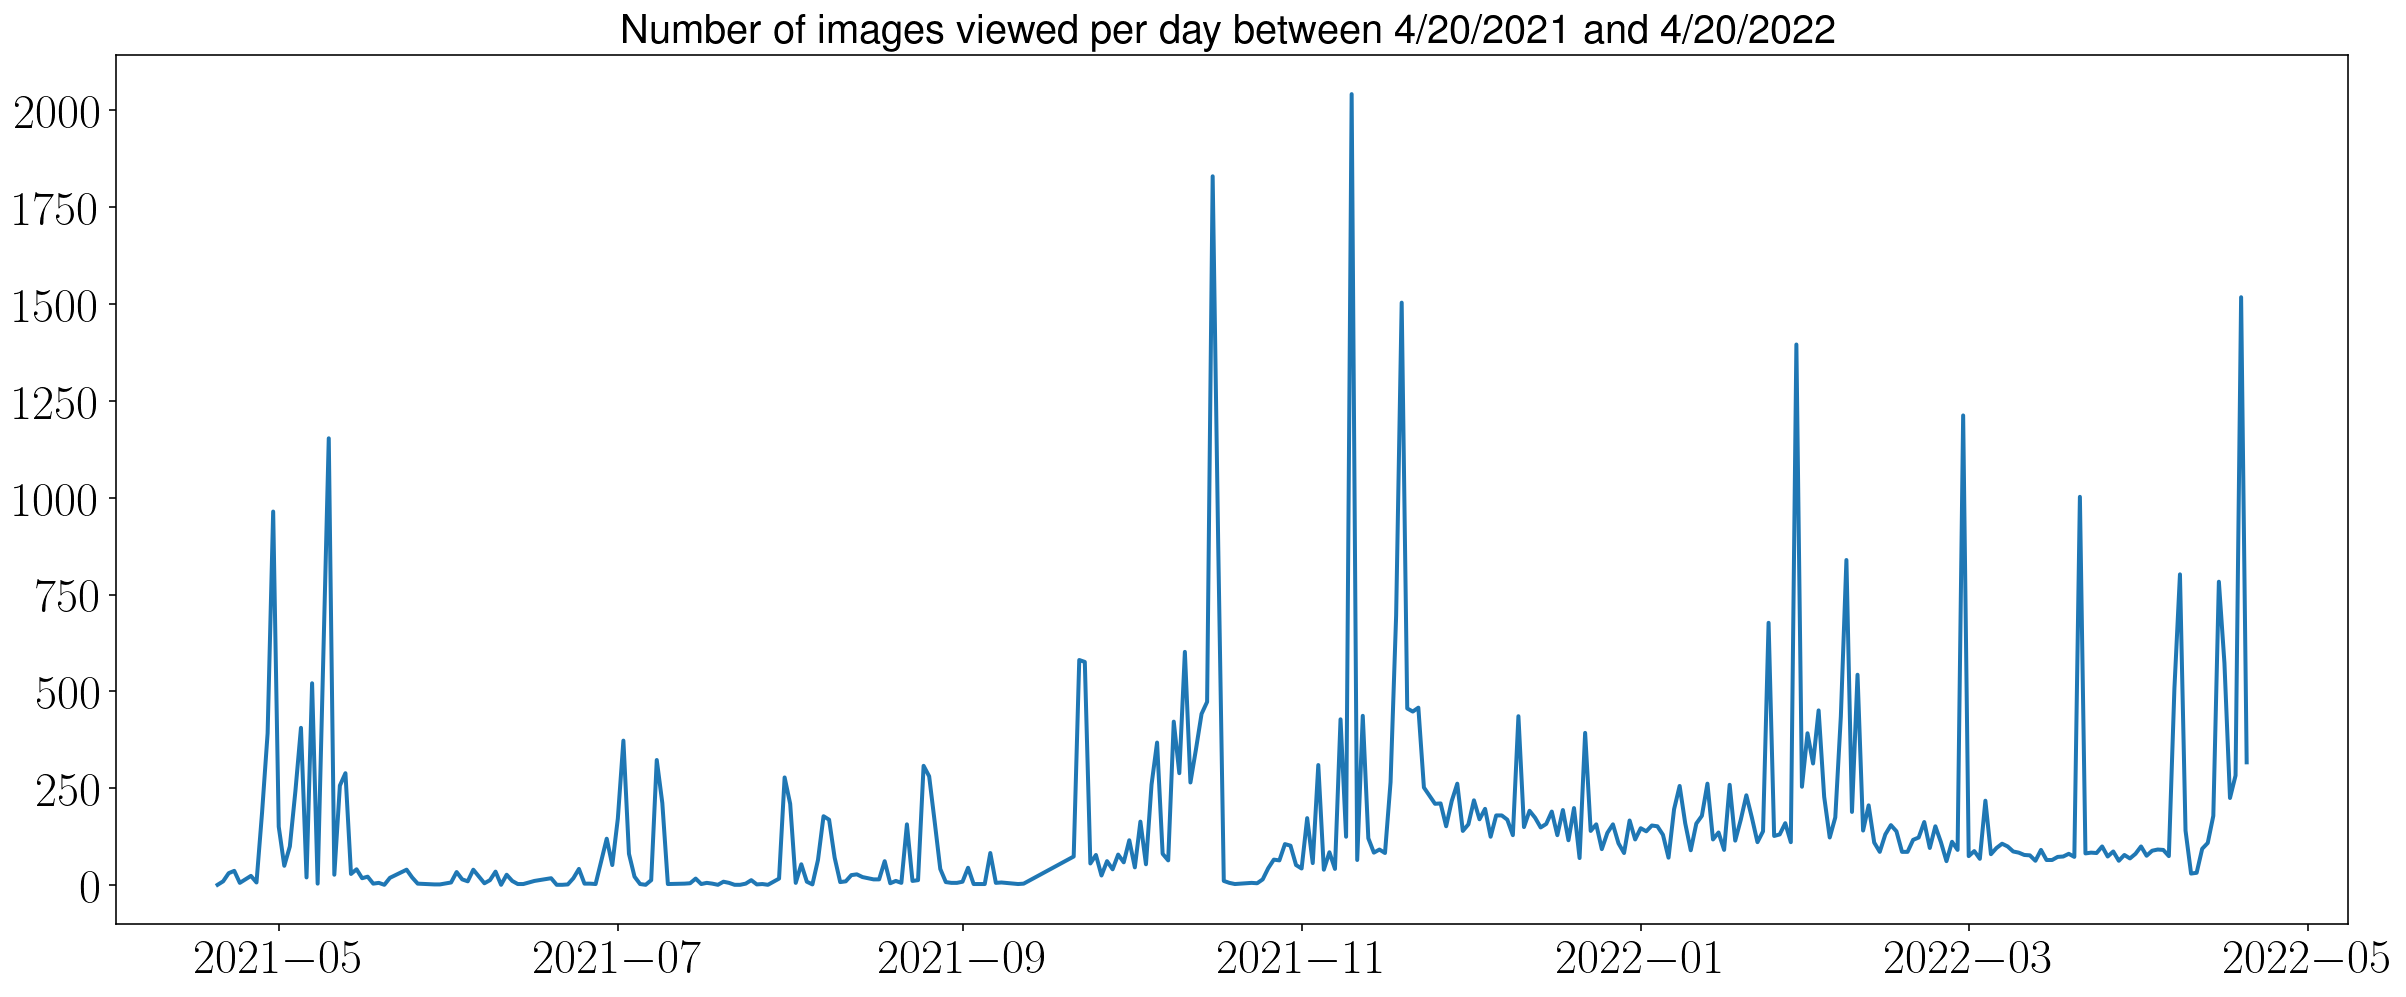

In [5]:
assert df.groupby(df.create_dt.dt.date).count()['session_id'].sum()==len(df), 'Total number of images viewed does not match after grouping by day!'
df.groupby(df.create_dt.dt.date).count()['session_id']
fig, ax = plt.subplots()
ax.plot(df.groupby(df.create_dt.dt.date).count()['session_id'], linewidth=2.0)
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(20)
ax.set_title(f'Number of images viewed per day between 4/20/2021 and {ENDTIME}', fontsize=20)
plt.savefig(EXPORTDIR+'images_viewed_per_day.png',dpi=300)
plt.savefig(EXPORTDIR+'images_viewed_per_day.pdf')
plt.show()

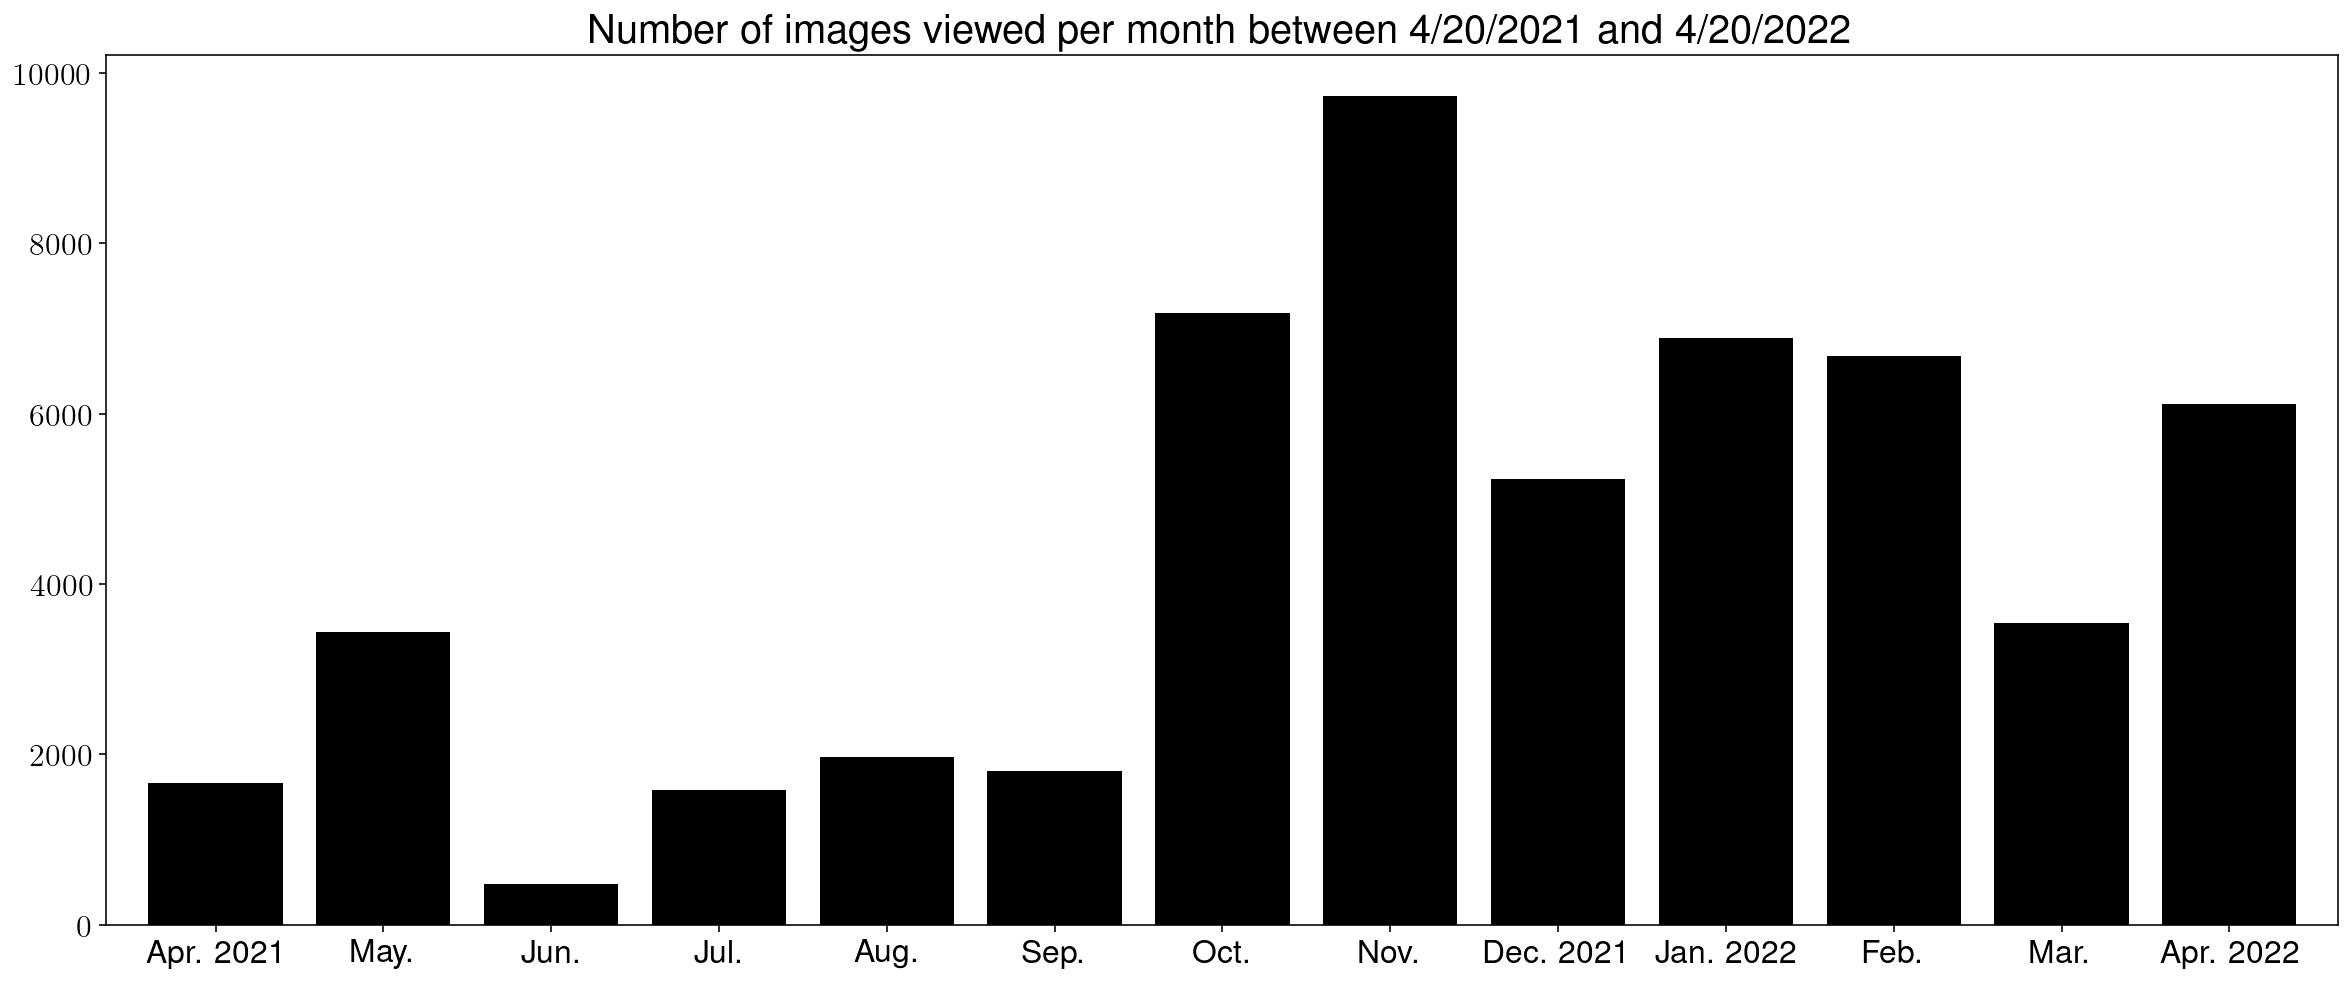

In [6]:
monthly = df.groupby([df.create_dt.dt.year,df.create_dt.dt.month]).count()['session_id']
assert monthly.sum()==len(df), 'Total number of images viewed does not match after grouping by day!'
fig, ax = plt.subplots()
ax = monthly.plot.bar(rot=0,color='k',width=0.8)
ax.set_xlabel('')
ax.set_xticklabels(['Apr. 2021', 'May.', 'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec. 2021','Jan. 2022','Feb.', 'Mar.','Apr. 2022'])
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
ax.set_title(f'Number of images viewed per month between 4/20/2021 and {ENDTIME}', fontsize=20)
plt.savefig(EXPORTDIR+'images_viewed_per_month.png',dpi=300)
plt.savefig(EXPORTDIR+'images_viewed_per_month.pdf')
plt.show()

In [7]:
print(f"Number of visitors (unique sessions): {len(df.session_id.unique())}")

Number of visitors (unique sessions): 51159


In [8]:
n_images_viewed = df.session_id.value_counts().value_counts()
print(f"Maximum number of images viewed in session: {df.session_id.value_counts().max()} (session {df.session_id.value_counts().idxmax()})")
print(f"Number of session with a single image viewed: {n_images_viewed[1]}")
print(f"Number of session with two images viewed: {n_images_viewed[2]}")
print(f"Number of session with three images viewed: {n_images_viewed[3]}")

Maximum number of images viewed in session: 711 (session 8)
Number of session with a single image viewed: 50934
Number of session with two images viewed: 29
Number of session with three images viewed: 65


In [9]:
def n_or_less_viewed(v, first_n = 10, verbose = False):
    viewed = pd.Series(dtype='int32')
    if first_n > len(v):
       first_n = len(v)
    for i in range(1,first_n):
        viewed[str(i)] = v.get(i, 0)
    viewed[str(first_n) + '+'] = v[first_n-1:].sum()
    if verbose:
        print('\033[1m n  | Visitors viewed n images\033[0m')
        all = v.sum()
        for index, value in viewed.items():
            if index == str(first_n) + '+':
                print(f"{index:3} |{value:7} ({value*100/all:5.2f}%)")
            elif (int(index) < 6) or (int(index) > first_n-5):
                print(f"{int(index):2}  |{value:7} ({value*100/all:5.2f}%)")
            elif (int(index) == 6):
                print('...')
    return viewed

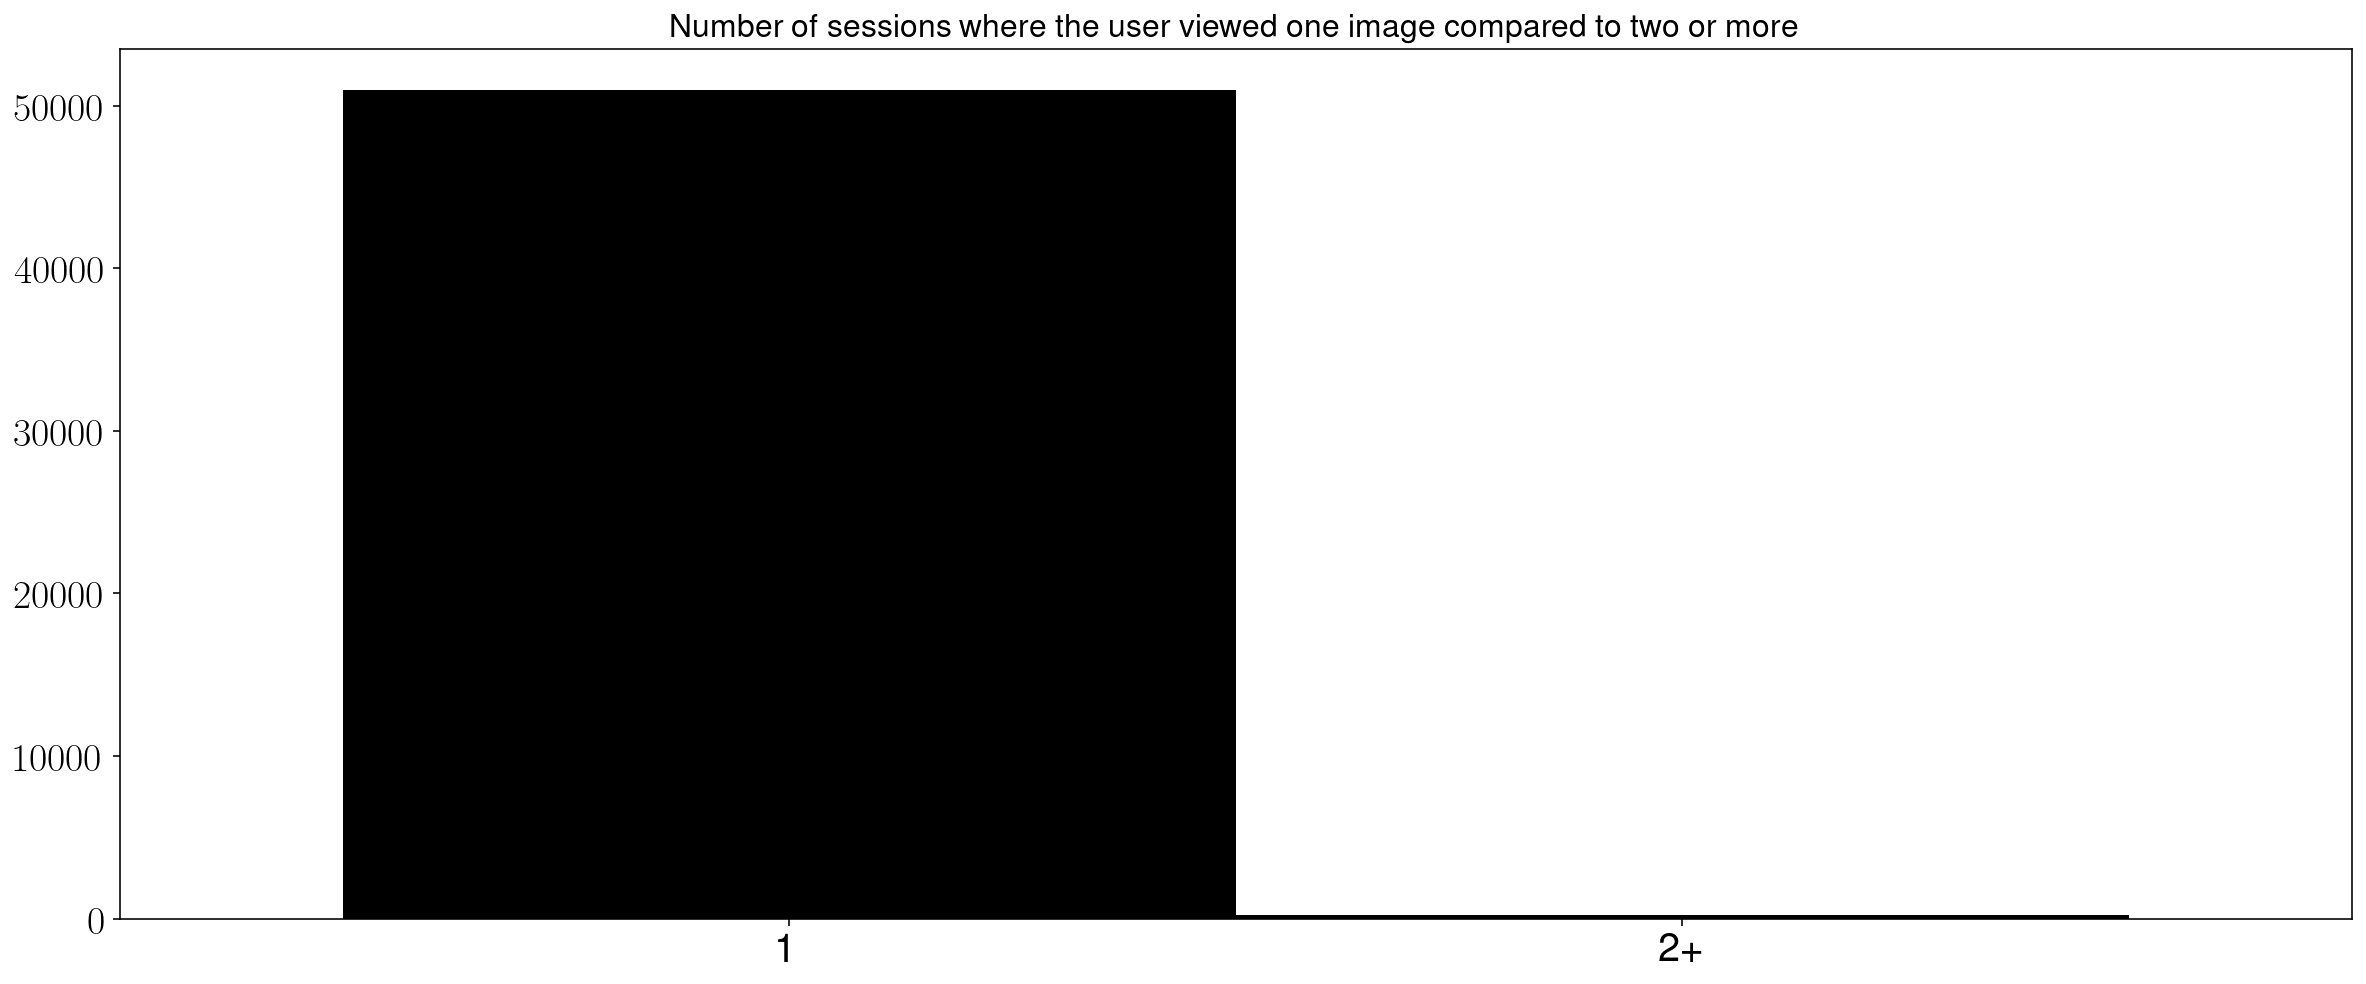

In [10]:
ax =  n_or_less_viewed(n_images_viewed[:], first_n = 2, verbose = False).plot.bar(rot=0,width=1,color='k')
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
ax.set_title('Number of sessions where the user viewed one image compared to two or more', fontsize=20)
plt.savefig(EXPORTDIR+'visitors_1_2_images.png',dpi=300)
plt.savefig(EXPORTDIR+'visitors_1_2_images.pdf')
plt.show()

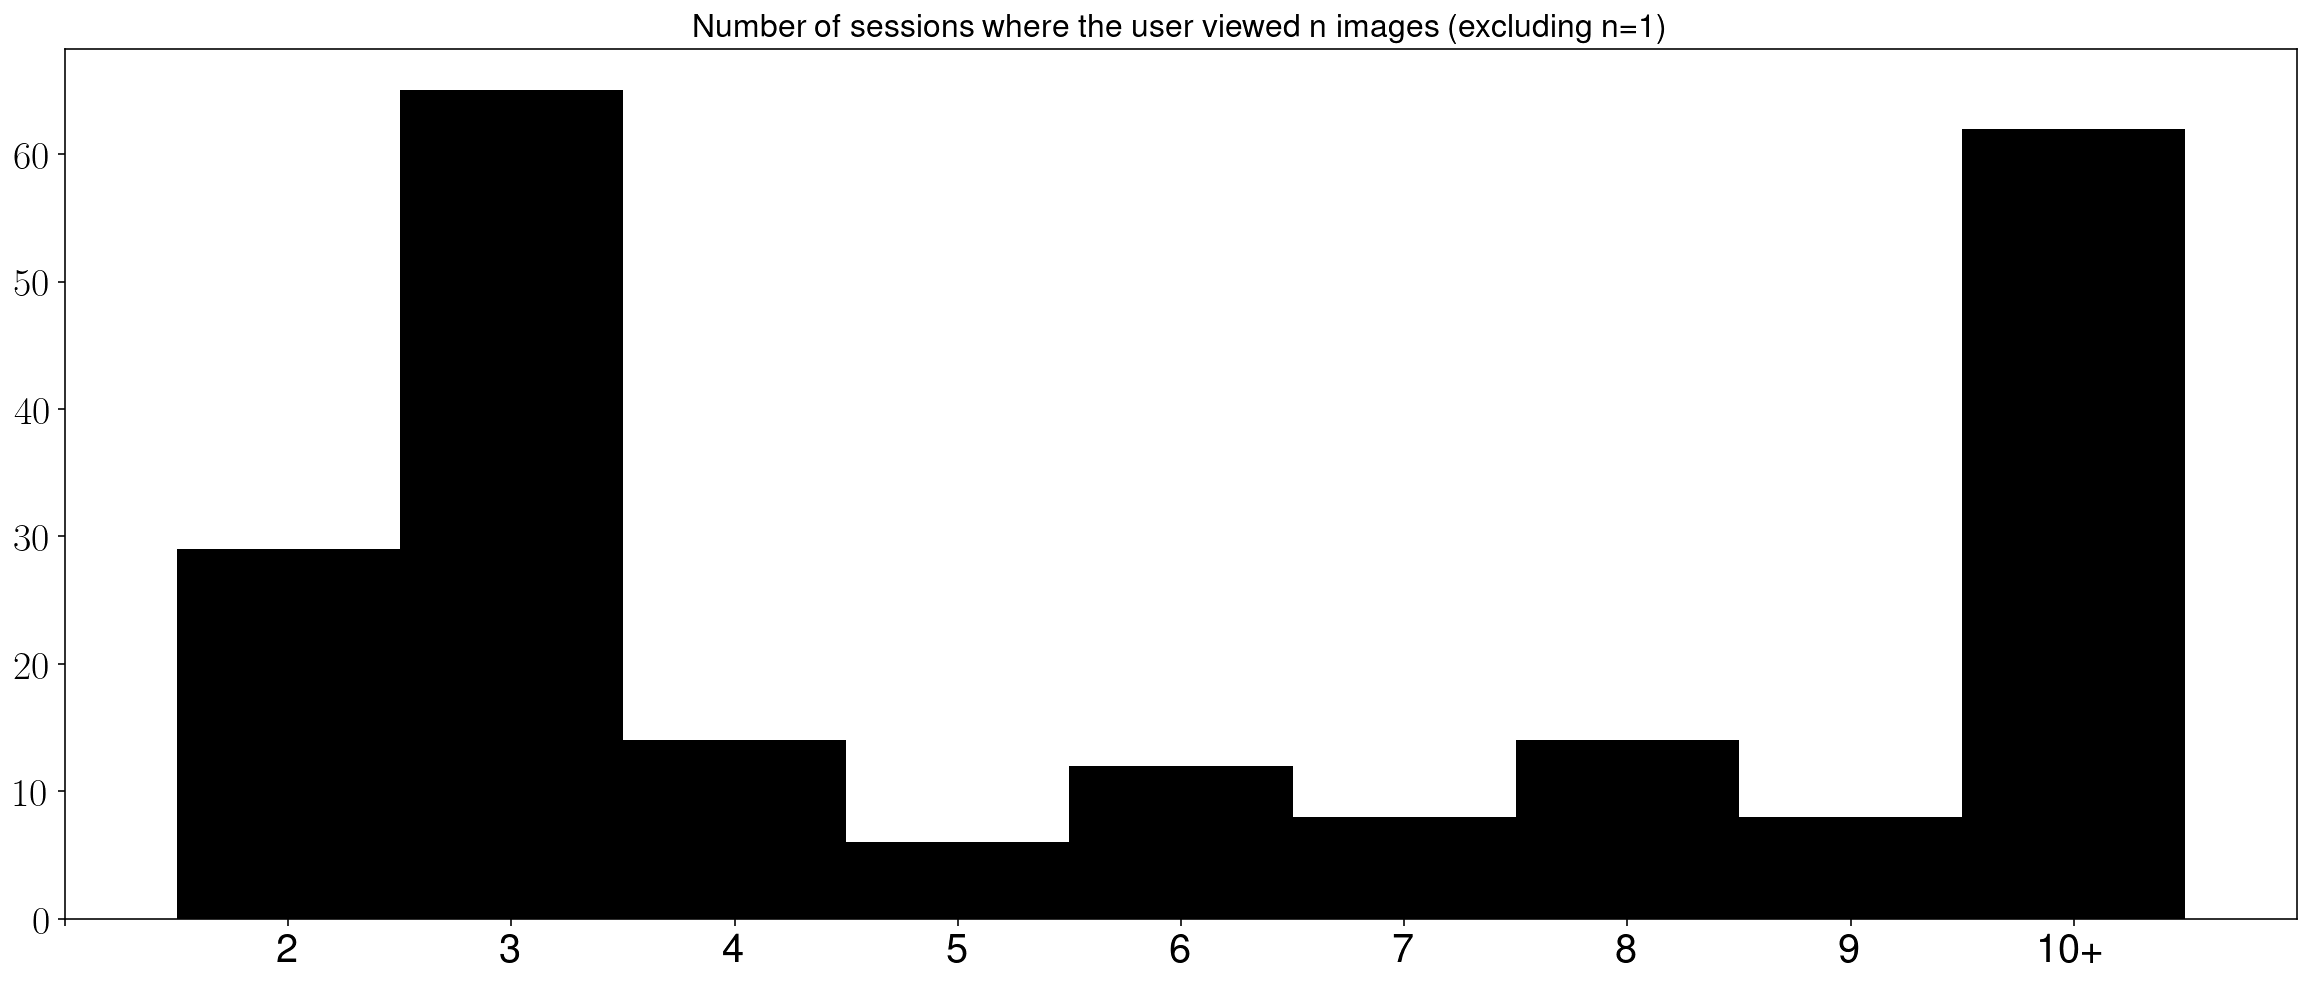

In [11]:
ax =  n_or_less_viewed(n_images_viewed[1:], first_n = 10, verbose = False).plot.bar(rot=0,width=1,color='k')
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
ax.set_xlim([0, 10])
ax.set_xticklabels(['', '2', '3', '4', '5', '6', '7', '8', '9', '10+'])
ax.set_title('Number of sessions where the user viewed n images (excluding n=1)', fontsize=20)
plt.savefig(EXPORTDIR+'visitors_n_images.png',dpi=300)
plt.savefig(EXPORTDIR+'visitors_n_images.pdf')
plt.show()

In [12]:
# Images viewed in session 1077
df[df.session_id == 1077]

,image_id,create_dt,session_id,mobile_user,mobile_image,response_yes,response_no,response_skip
3063,218,2021-05-19 10:34:26,1077,False,False,True,False,False
3064,253,2021-05-19 10:34:32,1077,False,False,True,False,False
3065,271,2021-05-19 10:34:38,1077,False,False,True,False,False
3066,263,2021-05-19 10:34:43,1077,False,False,True,False,False


In [13]:
print(f"Average number of images viewed per session: {df.session_id.value_counts().mean()}")

Average number of images viewed per session: 1.1000019546902793


## Mobile vs. non-mobile users

In [14]:
print(f"Average number of images viewed per {T.b}mobile{T.E} session: {df[df.mobile_user == True].session_id.value_counts().mean()}")

Average number of images viewed per mobile session: 1.1132372214941022


In [15]:
print(f"Average number of images viewed per {T.b}non-mobile{T.E} session: {df[df.mobile_user == False].session_id.value_counts().mean()}")

Average number of images viewed per non-mobile session: 1.0942844409782184


In [ ]:
# TODO: Add a plot mobile user vs non-mobile user

In [17]:
# TODO: Add a plot mobile user vs non-mobile user
# TODO: Add a plot of the number of -1/0/1
